In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from constants import LOCATION_CHOOSEN, INPUT_DIR, OUTPUT_DIR, DATA_CACHE_DIR, STRINGENCY_BASED_GDP

data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + ".csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel(os.path.join(INPUT_DIR, "owid-covid-data.xlsx"))
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

print(f'All columns in dataset: {df.columns}')

df = df[["date", "stringency_index", "total_cases", "total_deaths", "total_vaccinations", "population", "people_fully_vaccinated"]]

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
print(f'Before preprocessing: \n{missing_value_df}')

# preprocessing
df.ffill(inplace=True)
df.bfill(inplace=True)
df['date'] = pd.to_datetime(df['date'])

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
print(f'After preprocessing: \n{missing_value_df}')

mei_data = pd.read_csv(os.path.join(INPUT_DIR, "MEI_24112023074356372.csv"))
print(f'MEI data columns: {mei_data.columns}')
print(f'MEI data subjects: {mei_data["Subject"].unique()}')
print(f'MEI data locations: {mei_data["LOCATION"].unique()}')

All columns in dataset: Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinati

/tmp/ipykernel_22249/3570403271.py:39: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  mei_data = pd.read_csv(os.path.join(INPUT_DIR, "MEI_24112023074356372.csv"))


In [2]:
def merge_data(df, mei_data, subject_selected):
    subject_based_data = mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == subject_selected)]
    print(subject_selected, subject_based_data.shape[0])
    if subject_based_data.shape[0] > 0:
        subject_based_data.loc[:, 'TIME'] = pd.to_datetime(subject_based_data['TIME'])
        print(subject_based_data['TIME'].unique())
        merged_df = pd.merge(df, subject_based_data[['TIME', 'Value']], left_on='date', right_on='TIME', how='inner')
        merged_df.drop(columns=['TIME'], inplace=True)
        merged_df.rename(columns={'Value': "".join(subject_selected.split(">")[2:])}, inplace=True)
        df = merged_df
        return df

In [3]:
df = merge_data(df, mei_data, "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")
print(df)

Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised 89
['2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000'
 '2016-09-01T00:00:00.000000000' '2016-10-01T00:00:00.000000000'
 '2016-11-01T00:00:00.000000000' '2016-12-01T00:00:00.000000000'
 '2017-01-01T00:00:00.000000000' '2017-02-01T00:00:00.000000000'
 '2017-03-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2017-05-01T00:00:00.000000000' '2017-06-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2017-08-01T00:00:00.000000000'
 '2017-09-01T00:00:00.000000000' '2017-10-01T00:00:00.000000000'
 '2017-11-01T00:00:00.000000000' '2017-12-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2018-03-01T00:00:00.000000000' '2018-04-01T00:00:00.000000000'


/tmp/ipykernel_22249/1418267978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_based_data.loc[:, 'TIME'] = pd.to_datetime(subject_based_data['TIME'])
/tmp/ipykernel_22249/1418267978.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  subject_based_data.loc[:, 'TIME'] = pd.to_datetime(subject_based_data['TIME'])


In [4]:
df

,date,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,Gross Domestic Product (GDP) Normalised
0,2020-02-01,10.19,5.0,1.0,0.000000e+00,1417173120,7668.0,100.333420
1,2020-03-01,10.19,7.0,1.0,0.000000e+00,1417173120,7668.0,98.385188
2,2020-04-01,100.00,1637.0,38.0,0.000000e+00,1417173120,7668.0,88.535213
3,2020-05-01,96.30,35043.0,1147.0,0.000000e+00,1417173120,7668.0,83.728811
4,2020-06-01,87.50,190535.0,5394.0,0.000000e+00,1417173120,7668.0,87.992851
5,2020-07-01,87.50,585493.0,17400.0,0.000000e+00,1417173120,7668.0,92.262651
6,2020-08-01,85.65,1695988.0,36511.0,0.000000e+00,1417173120,7668.0,96.461990
7,2020-09-01,81.94,3691166.0,65288.0,0.000000e+00,1417173120,7668.0,97.751176
8,2020-10-01,70.83,6312584.0,98678.0,0.000000e+00,1417173120,7668.0,98.711405
9,2020-11-01,58.80,8184082.0,122111.0,0.000000e+00,1417173120,7668.0,98.663936


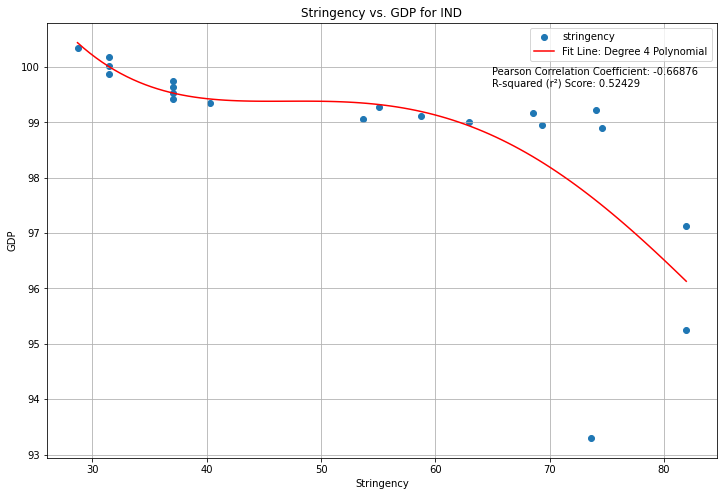

In [5]:
df = df[(df['date'].dt.year == 2021) & (df['date'].dt.month >= 5) | (df['date'].dt.year == 2022)]

stringency = df["stringency_index"]
gdp = df[' Gross Domestic Product (GDP)  Normalised']

correlation_coefficient, _ = pearsonr(stringency, gdp)

fit_coefficients = np.polyfit(stringency, gdp, 4)
fit_line = np.poly1d(fit_coefficients)

np.save('stringency_based_gdp.npy', fit_line)

r2 = r2_score(gdp, fit_line(stringency))

plt.figure(figsize=(12, 8))
plt.scatter(stringency, gdp, label="stringency")

stringency_range = np.linspace(min(stringency), max(stringency), 100)  # Generating a range for the fitted line
plt.plot(stringency_range, fit_line(stringency_range), color='red', label=f'Fit Line: Degree 4 Polynomial')
plt.figtext(0.64, 0.77, f'\nPearson Correlation Coefficient: {correlation_coefficient:.5f}\nR-squared (r²) Score: {r2:.5f}')

plt.title('Stringency vs. GDP for ' + LOCATION_CHOOSEN)
plt.xlabel('Stringency')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_vs_gdp_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [6]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_with_GDP.csv"), index=False)

93.06536784081368 123.14292816993668


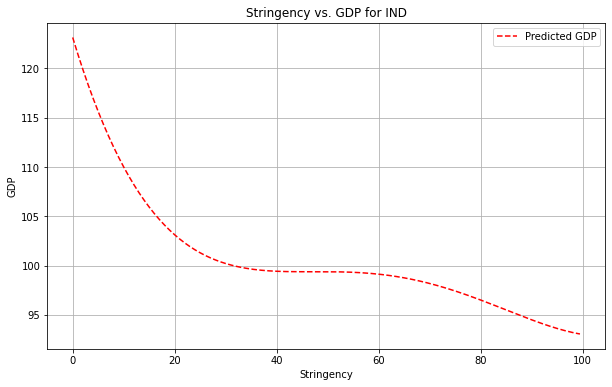

In [7]:
stringency_data_points = np.arange(0, 100, 0.5)
predicted_gdp = fit_line(stringency_data_points)

MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)
print(MIN_GDP, MAX_GDP)

plt.figure(figsize=(10, 6))
plt.plot(stringency_data_points, predicted_gdp, label="Predicted GDP", color='red', linestyle='--')
plt.title('Stringency vs. GDP for ' + LOCATION_CHOOSEN)
plt.xlabel('Stringency')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_vs_gdp_extended_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [8]:
# check save and load
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
print(fit_line_loaded(100.0))

93.02187092221976
